In [1]:
import dask.array as da
import napari
import btrack
from tqdm.auto import tqdm
from skimage.io import imshow,  imsave, imread
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import itertools
import json

plt.rcParams["figure.figsize"] = (15,7)

# Loading images

In [2]:
%%time
image = imread('/mnt/DATA/sandbox/lung_on_chip/monolayer/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.vsi - 005 CF405, CF488, CF561, CF638.tif')

CPU times: user 1.13 s, sys: 1.02 s, total: 2.15 s
Wall time: 2.14 s


In [3]:
import enum
@enum.unique
class Channels(enum.Enum): ### this is unique to the above acquisition (20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.vsi - 005 CF405, CF488, CF561, CF638.tif)
    DAPI = 0
    NKX21 = 1
    PDPN = 2
    ZO1 = 3

### crop image to dispose of blank z slices

In [4]:
image.shape

(81, 2304, 2304, 4)

In [5]:
image = image[25:45]

In [6]:
image.shape

(20, 2304, 2304, 4)

In [7]:
ch0 = image[...,0]
ch1 = image[...,1]
ch2 = image[...,2]
ch3 = image[...,3]

# Segment images

###### Initialise gpu

In [14]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Mon Oct 31 15:46:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.07    Driver Version: 515.65.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:65:00.0  On |                  Off |
| 30%   38C    P8    33W / 300W |   1452MiB / 49140MiB |      3%      Default |
|                               |                      |                  N/A |
+

In [11]:
%%time
# define model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=use_GPU, model_type='cyto')
# define CHANNELS to run segementation on
channels = [0,0]
### define empty mask stack 
mask_stack = []
### iterate over frames
for frame in tqdm(ch3, total = len(ch3)):
    ### run segmentation
    masks, flows, styles, diams = model.eval(frame, diameter=None, flow_threshold=None, channels=channels)
    ### append to mask stack
    mask_stack.append(masks)
mask_stack = np.stack(mask_stack, axis = 0)
#mask_stack.to_zarr(f"/mnt/DATA/sandbox/ch99.zarr/", overwrite=False)

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 4min 20s, sys: 34.9 s, total: 4min 55s
Wall time: 4min 36s


In [12]:
imsave('/mnt/DATA/sandbox/lung_on_chip/monolayer/cropped_[25:45]_masks.tif', mask_stack)

### Skip to load if already segmented

In [8]:
mask_stack = imread('/mnt/DATA/sandbox/lung_on_chip/monolayer/cropped_[25:45]_masks.tif')

### Defining properties to measure similarities of z-slices

Can use these features in latest version of btrack to aid in tracking by comparing features per-frame

In [9]:
props = ('axis_major_length', 
         'axis_minor_length', 
         'eccentricity', 
         'area', 
         'mean_intensity', 
         #'intensity_image', 
         'orientation')

In [10]:
image.shape

(20, 2304, 2304, 4)

In [11]:
objects = btrack.utils.segmentation_to_objects(
    mask_stack, 
    image,
    properties = props, 
    use_weighted_centroid=False)

[INFO][2022/11/01 12:29:54 PM] Localizing objects from segmentation...
[INFO][2022/11/01 12:29:54 PM] Found intensity_image data
[INFO][2022/11/01 12:30:15 PM] Objects are of type: <class 'dict'>
[INFO][2022/11/01 12:30:15 PM] ...Found 54892 objects in 20 frames.


In [12]:
objects[0]

,ID,x,y,z,t,dummy,states,label,prob,axis_major_length,axis_minor_length,eccentricity,area,mean_intensity-0,mean_intensity-1,mean_intensity-2,mean_intensity-3,orientation
0,0,392.458115,8.020942,0.0,0,False,0,5,0.0,27.613145,18.401359,0.745596,382,130.358639,110.363874,174.395288,110.861257,-1.552149


##### Tracking objs

In [13]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:
  # configure the tracker using a config file
  tracker.configure('/home/dayn/analysis/BayesianTracker/models/particle_config.json')
  # append the objects to be tracked
  tracker.append(objects)
  # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
  tracker.volume = ((0, 2304), (0, 2304))
  # track them (in interactive mode)
  tracker.track_interactive(step_size=100)
  # generate hypotheses and run the global optimizer
  tracker.optimize()
  # get the tracks as a python list
  tracks = tracker.tracks
  # filter tracks
  tracks = [track for track in tracks if len(track) >= 3]
  # optional: get the data in a format for napari
  data, properties, graph = tracker.to_napari()

[INFO][2022/11/01 12:30:15 PM] Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
[INFO][2022/11/01 12:30:15 PM] btrack (v0.4.5) library imported
[INFO][2022/11/01 12:30:15 PM] Starting BayesianTracker session
[INFO][2022/11/01 12:30:15 PM] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/particle_config.json
[INFO][2022/11/01 12:30:15 PM] Objects are of type: <class 'list'>
[INFO][2022/11/01 12:30:15 PM] Starting tracking... 
[INFO][2022/11/01 12:30:16 PM] Tracking objects in frames 0 to 20 (of 20)...
[INFO][2022/11/01 12:39:39 PM]  - Timing (Bayesian updates: 250.90ms, Linking: 15.86ms)
[INFO][2022/11/01 12:39:39 PM]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/11/01 12:39:39 PM] SUCCESS.
[INFO][2022/11/01 12:39:39 PM]  - Found 10191 tracks in 20 frames (in 0.0s)
[INFO][2022/11/01 12:39:39 PM]  - Inserted 3064 dummy objects to fill tracking gaps
[INFO][2022/11/01 12:39:39 PM] Loading hypothesis mod

GLPK Integer Optimizer 5.0
40764 rows, 36253 columns, 52124 non-zeros
36253 integer variables, all of which are binary
Preprocessing...
20382 rows, 36253 columns, 52124 non-zeros
36253 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 20382
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
20382 rows, 36253 columns, 52124 non-zeros
*     0: obj =   9.093362532e+04 inf =   0.000e+00 (10626)
Perturbing LP to avoid stalling [769]...
*  6309: obj =   5.468005750e+04 inf =   0.000e+00 (2677) 2
Removing LP perturbation [8797]...
*  8797: obj =   5.079072059e+04 inf =   0.000e+00 (0) 3
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  8797: mip =     not found yet >=              -inf        (1; 0)
+  8797: >>>>>   5.079072059e+04 >=   5.079072059e+04   0.0% (1; 0)
+  8797: mip =   

[INFO][2022/11/01 12:39:49 PM] Ending BayesianTracker session


In [14]:
track = tracks[0]
track

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity-0,orientation,area,axis_minor_length,mean_intensity-1,eccentricity,mean_intensity-3,axis_major_length,mean_intensity-2
0,249,0,936.276316,4.782895,0.0,249,249,5,0,False,108.940789,1.353953,152.0,8.283823,106.736842,0.955675,102.934211,28.135619,124.611842
1,249,1,936.276316,4.782895,0.0,249,249,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,249,2,954.111489,13.088511,0.0,249,249,5,0,False,126.525957,1.253553,1175.0,25.171128,112.425532,0.910171,105.844255,60.765751,145.525957
3,249,3,954.094536,12.803122,0.0,249,249,5,0,False,133.771032,1.272991,1153.0,25.154871,114.293148,0.908695,107.304423,60.257003,160.717259
4,249,4,953.237569,12.458564,0.0,249,249,5,0,False,143.302947,1.265452,1086.0,23.726326,119.073665,0.917433,108.042357,59.630154,182.634438
5,249,5,953.189236,12.629340,0.0,249,249,5,0,False,166.092882,1.289878,1152.0,24.153422,127.302083,0.920153,112.963542,61.685307,219.818576
6,249,6,953.570863,13.035629,0.0,249,249,5,0,False,201.126683,1.291549,1263.0,25.389554,139.121140,0.918887,121.927949,64.355443,270.464766
7,249,7,954.778182,13.677818,0.0,249,249,5,0,False,252.410909,1.285253,1375.0,26.481379,157.090182,0.919305,135.199273,67.289014,326.021091
8,249,8,953.585670,13.577882,0.0,249,249,5,0,False,291.235202,1.296904,1284.0,26.410258,171.357477,0.907945,130.898754,63.018197,347.769470
9,249,9,951.431102,12.369094,0.0,249,249,5,0,False,301.447835,1.295192,1016.0,23.151007,176.244094,0.913558,123.546260,56.922897,321.000000


### Extracting single cell measures

 but first checking channel enumerations

In [297]:
import napari

v = napari.Viewer()

v.add_image(ch0, name = Channels.DAPI.name, blending = 'additive', colormap='blue')
v.add_image(ch1, name = Channels.NKX21.name, blending = 'additive', colormap='green')
v.add_image(ch2, name = Channels.PDPN.name, blending = 'additive', colormap='red')
v.add_image(ch3, name = Channels.ZO1.name, blending = 'additive', colormap='gray')
v.add_labels(mask_stack)
v.add_tracks(data)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'data' at 0x7f377809c850>

In [28]:
import pandas as pd

In [56]:
cols = ['Cell ID', 'Max. int. DAPI', 'Max. int. NKX21', 'Max. int. PDPN', 'Max. int. ZO1', 'x', 'y']

In [89]:
df = pd.DataFrame([(track.ID, np.nanmax(track['mean_intensity-0']),np.nanmax(track['mean_intensity-1']),np.nanmax(track['mean_intensity-2']),np.nanmax(track['mean_intensity-3']), np.mean(track.x), np.mean(track.y)) for track in tracks], columns= cols)
pd.DataFrame([(track.ID, np.nanmax(track['mean_intensity-0']),np.nanmax(track['mean_intensity-1']),np.nanmax(track['mean_intensity-2']),np.nanmax(track['mean_intensity-3']), np.mean(track.x), np.mean(track.y)) for track in tracks], columns= cols)

,Cell ID,Max. int. DAPI,Max. int. NKX21,Max. int. PDPN,Max. int. ZO1,x,y
0,249,301.447835,176.244094,347.769470,135.199273,950.055128,11.320575
1,260,1660.750000,819.633333,651.004104,134.643639,1371.656425,15.771481
2,259,675.338376,355.360777,493.353503,129.640127,2121.861659,12.777158
3,258,1150.301205,431.990361,1205.507837,133.434066,238.755957,6.475418
4,257,412.382098,234.673347,439.279769,128.212425,350.520471,15.824814
...,...,...,...,...,...,...,...
5322,9825,1429.236364,549.181818,1125.775510,253.359184,2271.978656,1966.256476
5323,9659,1267.489130,776.347826,547.527273,386.927273,669.513757,2266.294713
5324,9702,740.683824,325.926471,1076.066667,246.566667,3.957939,2177.522073
5325,10039,231.741935,159.129032,205.427419,196.948718,165.368762,32.066998


In [73]:
[track for track in tracks if track.ID == 10039][0]

,ID,t,x,y,z,parent,root,state,generation,dummy,axis_major_length,mean_intensity-1,area,axis_minor_length,orientation,mean_intensity-3,mean_intensity-2,mean_intensity-0,eccentricity
0,10039,17,163.564516,33.516129,0.0,10039,10039,5,0,False,14.284780,150.258065,124,11.153046,-0.849973,148.564516,205.427419,223.669355,0.624826
1,10039,18,166.516129,30.838710,0.0,10039,10039,5,0,False,7.672945,159.129032,31,5.558694,-0.487105,168.161290,197.903226,231.741935,0.689323
2,10039,19,166.025641,31.846154,0.0,10039,10039,5,0,False,7.600571,146.692308,39,6.935310,0.274687,196.948718,185.897436,213.230769,0.409139


In [104]:
import seaborn as sns
import os

In [102]:
output_dir = '/home/dayn/Documents/presentations/221101_LoC'

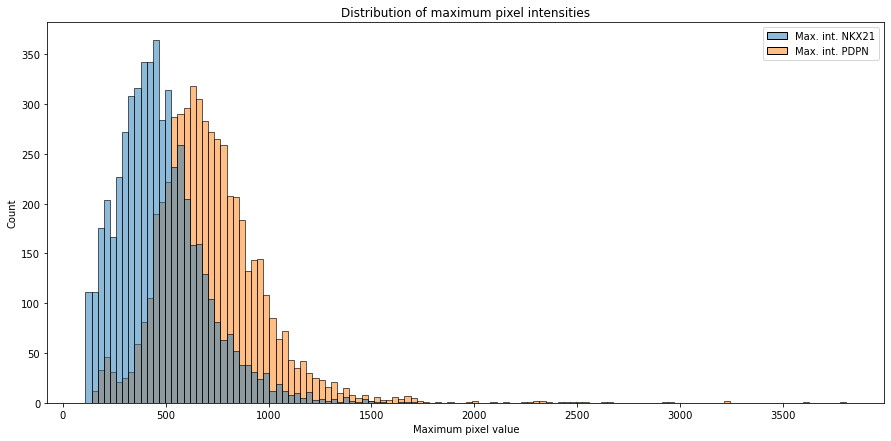

In [105]:
sns.histplot((df['Max. int. NKX21'], df['Max. int. PDPN']))
plt.title('Distribution of maximum pixel intensities')
plt.xlabel('Maximum pixel value')
plt.savefig(os.path.join(output_dir, 'max_int_dist.jpg'), dpi = 314, bbox_inches = 'tight')

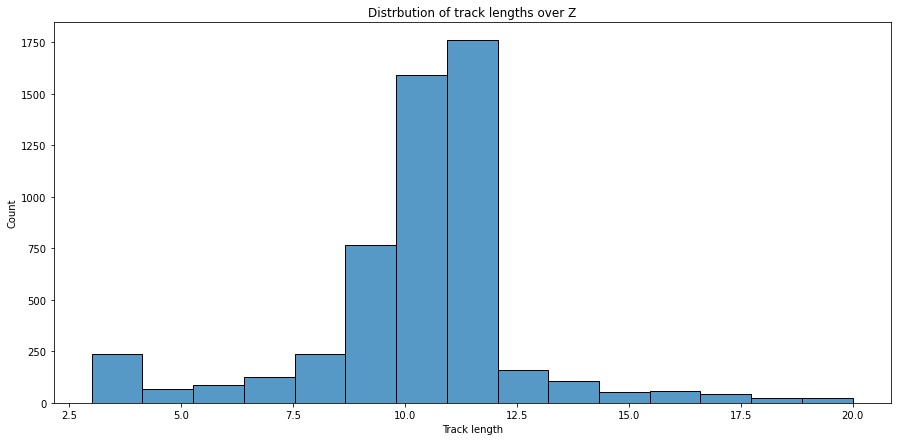

In [106]:
sns.histplot([len(track) for track in tracks], bins = 15)
plt.title('Distrbution of track lengths over Z')
plt.xlabel('Track length')
plt.savefig(os.path.join(output_dir, 'track_length_dist.jpg'), dpi = 314, bbox_inches = 'tight')

## Filtering track lengths

In [15]:
filtered_tracks = [track for track in tracks if len(track) > 7]

In [82]:
filtered_df = pd.DataFrame([(track.ID, np.nanmax(track['mean_intensity-0']),np.nanmax(track['mean_intensity-1']),np.nanmax(track['mean_intensity-2']),np.nanmax(track['mean_intensity-3']), np.mean(track.x), np.mean(track.y)) for track in filtered_tracks], columns= cols)
filtered_df

,Cell ID,Max. int. DAPI,Max. int. NKX21,Max. int. PDPN,Max. int. ZO1,x,y
0,249,301.447835,176.244094,347.769470,135.199273,950.055128,11.320575
1,260,1660.750000,819.633333,651.004104,134.643639,1371.656425,15.771481
2,259,675.338376,355.360777,493.353503,129.640127,2121.861659,12.777158
3,258,1150.301205,431.990361,1205.507837,133.434066,238.755957,6.475418
4,257,412.382098,234.673347,439.279769,128.212425,350.520471,15.824814
...,...,...,...,...,...,...,...
4808,8201,1467.596639,885.277311,652.621495,175.070093,1559.474781,1914.404537
4809,8323,314.666667,171.900000,1099.533333,266.453333,2144.336086,264.639448
4810,8527,1265.281553,784.461165,849.706714,187.769231,1571.751283,1902.370323
4811,8609,300.933798,170.275261,309.250871,209.336245,2088.909998,467.305009


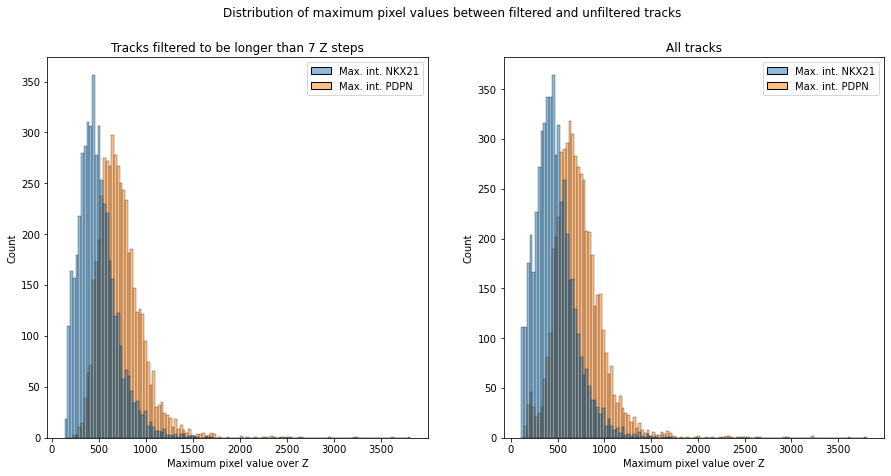

In [107]:
fig, ax =plt.subplots(1,2)
fig.suptitle('Distribution of maximum pixel values between filtered and unfiltered tracks')
sns.histplot((filtered_df['Max. int. NKX21'], filtered_df['Max. int. PDPN']), ax = ax[0])
ax[0].set_title('Tracks filtered to be longer than 7 Z steps')
ax[0].set(xlabel = 'Maximum pixel value over Z')
sns.histplot((df['Max. int. NKX21'], df['Max. int. PDPN']), ax = ax[1])
ax[1].set_title('All tracks')
ax[1].set(xlabel = 'Maximum pixel value over Z')
plt.savefig(os.path.join(output_dir, 'max_int_dist_filtered_comparison.jpg'), dpi = 314, bbox_inches = 'tight')

# Need to define a cut-off for a "positive" PDPN and NKX21 value

Generate glimpses and ask if a or b?

In [19]:
def make_glimpse(random_coords, image, mask_stack, size = 100):
    
    ### get coords of glimpse
    y, x, t = random_coords
    
    ### select frame of interest
    frame = image[t]
    ch1_frame = frame[...,1]
    ch2_frame = frame[...,2]
    ch3_frame = frame[...,3]
    mask_frame = mask_stack[t]

    ### obtain coordinates of bounding box of glimpse (centered on cell)
    x1, x2, y1, y2 = x, x+size, y, y+size #coordinates to crop by, shifted bearing in mind a further coord shift (+100,+100) occurs due to image padding            
    ### pad image incase cell goes off FOV
    ch1_frame = np.pad(ch1_frame, int(size/2), 'constant', constant_values = 0) 
    ch2_frame = np.pad(ch2_frame, int(size/2), 'constant', constant_values = 0) 
    ch3_frame = np.pad(ch3_frame, int(size/2), 'constant', constant_values = 0) 
    mask_frame = np.pad(mask_frame, int(size/2), 'constant', constant_values = 0) 
    ## glimpse creation by cropping original image
    ch1_glimpse = ch1_frame[int(x1): int(x2), int(y1): int(y2)]
    ch2_glimpse = ch2_frame[int(x1): int(x2), int(y1): int(y2)]
    ch3_glimpse = ch3_frame[int(x1): int(x2), int(y1): int(y2)]
    ### mask outline creation 
    mask_glimpse = mask_frame[int(x1): int(x2), int(y1): int(y2)]
    ### find pixel value of mask to extract single mask
    mask_pix_val = mask_glimpse[int(size/2),int(size/2)]
    mask_glimpse = (mask_glimpse ==mask_pix_val).astype(int)
    ### create outline
    mask_glimpse_erode = binary_erosion(mask_glimpse).astype(int)
    outline = np.logical_xor(mask_glimpse_erode, mask_glimpse)
    
    return ch1_glimpse, ch2_glimpse, ch3_glimpse, outline

In [21]:
import random
import warnings
warnings.filterwarnings("ignore")
from skimage.morphology import binary_erosion

In [ ]:
for track in (filtered_tracks):
    ## randomly select which channel to choose from 
    if random.randint(0,1) <1:
        print('Channel 1, KXC21')
        ### extracting index of maximum intensity value
        max_int = np.nanmax(track['mean_intensity-1'])
        index_max_value = np.where(track['mean_intensity-1'] == max_int)[0][0]
        ### extracting xyt coordinates of that cell at that time
        random_coords = (track.x[index_max_value], track.y[index_max_value], track.t[index_max_value])
        ### print selected glimpse info
        print(f"Track ID:{track.ID}, xyt:{random_coords}")
        ### make ch1 glimpse
        ch1_glimpse, _, ch3_glimpse, outline = make_glimpse(random_coords, image, mask_stack, size = 100)
        ### multiply the outline to both highlight it in the composite and fix the upper bound of the colormap
        outline = outline *1000
        ### launch a napari viewer to show glimpse
        viewer = napari.Viewer()
        viewer.add_image(ch1_glimpse, colormap = 'green', blending = 'additive', name = 'NKX21')
        viewer.add_image(ch3_glimpse, colormap = 'gray', blending = 'additive', name = 'ZO1')
        viewer.add_image(outline, colormap = 'magenta', blending = 'additive', name = 'Mask')
        ### wait until image is closed to enter pos or negative 
        viewer.show(block=True)
        ####
        print("Enter positive/negative as \"p\" or \"n\" for NKX21")
        ch1_val = input()
        ### record result
        if ch1_val == 'p':
            with open("NKCX21_positive.csv","a") as f:
                f.write(f"{max_int}\n")
        elif ch1_val == 'n':
            with open("NKCX21_negative.csv","a") as f:
                f.write(f"{max_int}\n")
        else:
            print('Did not recognise the positive/negative text input')
    ### now the other channel     
    else:
        print('Channel 2, PDPN')
        ### extracting index of maximum intensity value
        max_int = np.nanmax(track['mean_intensity-2'])
        index_max_value = np.where(track['mean_intensity-2'] == max_int)[0][0]
        ### extracting xyt coordinates of that cell at that time
        random_coords = (track.x[index_max_value], track.y[index_max_value], track.t[index_max_value])
        ### print selected glimpse info
        print(f"Track ID:{track.ID}, xyt:{random_coords}")
        ### make ch2 glimpse
        _, ch2_glimpse, ch3_glimpse, outline = make_glimpse(random_coords, image, mask_stack, size = 100)
        ### multiply the outline to both highlight it in the composite and fix the upper bound of the colormap
        outline = outline *1000
        ### launch a napari viewer to show glimpse
        viewer = napari.Viewer()
        viewer.add_image(ch2_glimpse, colormap = 'red', blending = 'additive', name = 'PDPN')
        viewer.add_image(ch3_glimpse, colormap = 'gray', blending = 'additive', name = 'ZO1')
        viewer.add_image(outline, colormap = 'magenta', blending = 'additive', name = 'Mask')
        ### wait until image is closed to enter pos or negative 
        viewer.show(block=True)
        ####
        print("Enter positive/negative as \"p\" or \"n\" for PDPN")
        ch1_val = input()
        ### record result
        if ch1_val == 'p':
            with open("PDPN_positive.csv","a") as f:
                f.write(f"{max_int}\n")
        elif ch1_val == 'n':
            with open("PDPN_negative.csv","a") as f:
                f.write(f"{max_int}\n")
        else:
            print('Did not recognise the positive/negative text input')

Channel 2, PDPN
Track ID:249, xyt:(953.5856697819314, 13.577881619937695, 8)
Enter positive/negative as "p" or "n" for PDPN
n
Channel 2, PDPN
Track ID:260, xyt:(1371.6518467852256, 15.842681258549932, 9)


Enter positive/negative as "p" or "n" for PDPN
n
Channel 2, PDPN
Track ID:259, xyt:(2120.6568471337578, 17.035828025477706, 10)


Enter positive/negative as "p" or "n" for PDPN
n
Channel 2, PDPN
Track ID:258, xyt:(238.95611285266457, 6.29153605015674, 7)


Enter positive/negative as "p" or "n" for PDPN
n
Channel 2, PDPN
Track ID:257, xyt:(349.8994643592913, 22.450762257931604, 7)


Enter positive/negative as "p" or "n" for PDPN
n
Channel 1, KXC21
Track ID:256, xyt:(477.56996587030716, 9.496018202502844, 7)


Enter positive/negative as "p" or "n" for NKX21
n
Channel 2, PDPN
Track ID:255, xyt:(521.0646706586826, 32.22694610778443, 8)


Enter positive/negative as "p" or "n" for PDPN
n
Channel 2, PDPN
Track ID:254, xyt:(522.7280701754386, 4.337719298245614, 8)


Enter positive/negative as "p" or "n" for PDPN
n
Channel 2, PDPN
Track ID:252, xyt:(576.5497175141243, 15.792090395480226, 8)


Enter positive/negative as "p" or "n" for PDPN
n
Channel 2, PDPN
Track ID:251, xyt:(1777.4908647990255, 17.24969549330085, 8)


Enter positive/negative as "p" or "n" for PDPN
n
Channel 2, PDPN
Track ID:250, xyt:(877.770731707317, 5.678048780487805, 9)


Enter positive/negative as "p" or "n" for PDPN
n
Channel 2, PDPN
Track ID:261, xyt:(675.4297872340426, 21.072340425531916, 8)


Enter positive/negative as "p" or "n" for PDPN
n
Channel 1, KXC21
Track ID:248, xyt:(1000.0732240437159, 14.71584699453552, 9)


Enter positive/negative as "p" or "n" for NKX21
